# Basic Vision Transformer (ViT) with DINO (Knowledge Distillation with No Labels)

This notebook contains code (to be refactored into scripts at a later stage) that implements a basic ViT and ViT for use with DINO to be trained on MNIST, CIFAR10, and CIFAR100. 

The implementation is written using PyTorch and allows for the following options:

- Different datasets: MNIST, CIFAR10, and CIFAR100 (more to be added in future - please open an issue if you would like to see a specific dataset added)
- Image augmentation and resizing
- Different patch sizes
- Different number of layers
- Different number of heads
- Different number of channels
- Different number of classes
- Different number of epochs
- Different batch sizes
- Different learning rates
- Different optimizers
- Different weight decay
- Different dropout rates
- Different number of workers
- Different number of GPUs

The implementation is based on the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Dosovitskiy et al. and the paper [How to Train Vision Transformer on Small-scale Datasets?](https://arxiv.org/abs/2210.07240v1) by Gani et al. 

The purpose of this notebook is to provide a basic implementation of ViT that can be used as a starting point for more advanced implementations. The user has the flexibility to change the hyperparameters and the architecture to suit their needs by editing the configs. Thereafter, we investigate the use of knowledge distallation with no labels to train ViT on small-scale datasets as a pre-training step before fine-tuning on the small-scale dataset with labels. 

The code is optimised for readability and speed where possible.

In future the code will be refactored into scripts and the configs will be moved to a separate file, whereby the user can edit the configs in the file to suit their experimentation needs.

The first half of this notebook builds a basic ViT model and trains it on MNIST, CIFAR10, and CIFAR100. The second half of this notebook builds a ViT model for use with DINO and trains it on MNIST, CIFAR10, and CIFAR100.

The second half involves:

1. **Pre-training Stage (Self-Supervised)**: This is a two-step approach using local and global views of low-resolution images.
   - **Local Views**: Smaller sections or patches of the image.
   - **Global Views**: Represent the entire low-resolution image.

   A self-supervised task is designed where the student model predicts the teacher model's representations. The teacher is aided with Dynamic Position Embeddings (DPE) to capture spatial information of local and global views better.

2. **Weight Transfer**: After the pre-training is complete, the learned weights from the self-supervised training are used to initialise a standard ViT for the subsequent supervised training.

3. **Fine-tuning (Supervised)**: This is the phase where actual labeled data is introduced. The model, initialized with weights from the self-supervised phase, is trained on the small-scale dataset using supervised learning. This step leverages the inductive biases achieved during the self-supervised pre-training to ease the optimization of the Vision Transformer on small datasets.


- The student is trained to approximate the feature representations of the teacher during the self-supervised phase. It is trying to predict the output of the teacher model based on the local and global views.

- Once this self-supervised training is complete, you'd typically want to transfer the student's learned weights to a Vision Transformer, which will be used for the supervised fine-tuning phase.

We want to transfer the weights, but not directly from the teacher model. Instead, we transfer from the student model that has been trained to mimic the teacher during the self-supervised phase. This student model's weights serve as a good initialisation for supervised learning on small datasets.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time
import math
import random

# Machine learning imports
import torch
import torch.nn.functional as F
from torch import nn, Tensor, optim
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Third-party imports
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image
from tqdm import tqdm

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
dataset = "CIFAR100" # <-- change this parameter only! Options: MNIST, CIFAR10, CIFAR100
data_use = 50 # <-- change this parameter for scaling dataset in percentage! Options: 25, 50, 75, 100
model_name = f"{dataset}_{data_use}_classifier"
in_channels = 1 if dataset == "MNIST" else 3
num_classes = 100 if dataset == "CIFAR100" else 10
learning_rate = 0.002 #0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
self_supervised_epochs = 20
fine_tune_epochs = 20
image_size = 28 if dataset == "MNIST" else 32 # upscale CIFAR10 and CIFAR100 images for better performance -> INVESTIGATE
patch_size = 7 if dataset == "MNIST" else 8 # keep the number of patches the same for all datasets to keep experiments controlled
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8 # depth
mlp_head_units = [2048, 1024]
patience_value = 10 if dataset == "MNIST" else 15 # default: 10 if not set
dropout=0.01 # Adjust as necessary
ema_decay = 0.999  # Adjust only if necessary

In [3]:
def set_device():
    ''' 
    Set device: either Cuda (GPU), MPS (Apple Silicon GPU), or CPU
    '''
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    return device

In [4]:
def data_loader(dataset: str, batch_size: int, image_size: int, data_use: int = 100, augment: bool = True):
    '''
    Function that takes in a dataset and returns train and test dataloaders along with the hyperparameters
    associated with the dataset.

    Parameters:
        dataset (str): Name of dataset to load. Options: MNIST, CIFAR10, CIFAR100
        batch_size (int): Batch size for dataloaders
        augment (bool): Whether to augment training data or not
        
    Returns:
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        test_loader (DataLoader): Dataloader for test set
        num_classes (int): Number of classes in dataset
        image_size (int): Size of image in dataset
        batch_size (int): Batch size for dataloaders
    '''

    base_train_transforms = [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    if dataset == "MNIST":
        base_train_transforms.append(transforms.Normalize((0.5,), (0.5,)))
    elif dataset == "CIFAR10":
        mean, std = (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
        base_train_transforms.append(transforms.Normalize(mean, std))
    elif dataset == "CIFAR100":
        mean, std = (0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
        base_train_transforms.append(transforms.Normalize(mean, std))

    # Additional augmentations for CIFAR10 and CIFAR100
    additional_transforms = []
    if augment:

        additional_transforms = [
            transforms.Resize((image_size, image_size)), # resizing capabilities if needed. Currently not used for our experiments
            transforms.RandomCrop(image_size, padding=4),
            transforms.RandomHorizontalFlip(), 
            transforms.RandomRotation(3.6),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
        ]
    
    dataset_config = {
        'MNIST': {
            'dataset_cls': datasets.MNIST,
            'num_classes': 10,
            'default_image_size': 28,
            'batch_size': batch_size,  # Use the batch_size parameter
            'train_transform': transforms.Compose(base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        },
        'CIFAR10': {
            'dataset_cls': datasets.CIFAR10,
            'num_classes': 10,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
            ])
        },
        'CIFAR100': {
            'dataset_cls': datasets.CIFAR100,
            'num_classes': 100,
            'default_image_size': 32,
            'batch_size': batch_size,
            'train_transform': transforms.Compose(additional_transforms + base_train_transforms),
            'test_transform': transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
            ])
        }
    }    

    # Ensure dataset is valid
    if dataset not in dataset_config:
        raise ValueError(f"Unsupported dataset: {dataset}. Supported datasets are: {', '.join(dataset_config.keys())}")

    # Access config
    cfg = dataset_config[dataset]

    # Print loading info
    print(f'Loading {dataset} dataset...')

    # Load data
    dataset_cls = cfg['dataset_cls']

    data_dir = '../data/'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    train_dataset_full = dataset_cls(f'{data_dir}{dataset}_data/', train=True, download=True, transform=cfg['train_transform'])
    # decrease the amount of training data to data_use percentage
    train_dataset_full, _ = train_test_split(train_dataset_full, train_size=data_use/100, random_state=42, shuffle=True, stratify=train_dataset_full.targets)

    test_dataset = dataset_cls(f'{data_dir}{dataset}_data/', train=False, download=True, transform=cfg['test_transform'])
    # decrease the amount of test data to data_use value
    test_dataset, _ = train_test_split(test_dataset, train_size=data_use/100, random_state=42, shuffle=True, stratify=test_dataset.targets)

    # Split training dataset into training and validation sets
    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    # Compute optimal number of workers
    num_workers = min(4, os.cpu_count())

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, cfg['num_classes'], cfg['default_image_size']


In [5]:
class PatchEmbedding(nn.Module):
    '''
    Class that creates patch embeddings for images
    (image to patch embeddings).

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension

    Returns:
        x (Tensor): Patch embeddings
    '''
    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x: Tensor) -> Tensor:
        
        x = self.projection(x).flatten(2).transpose(1, 2)
        return x

In [6]:
class Attention(nn.Module):
    '''
    Class that creates an attention layer.

    Parameters:
        dim (int): Dimension of input
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of attention layer
    '''
    
    def __init__(self, 
                dim: int, 
                heads: int, 
                dim_head: int, 
                dropout: float=0.):
        super().__init__()
        
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        # Linear layer to get Q, K, V
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attend = nn.Softmax(dim=-1)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        
        # Obtain Q, K, V from input tensor x
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, self.dim_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores and apply scaling
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        
        # Softmax to get attention weights
        attn = self.attend(dots)
        
        # Calculate the output tensor
        out = torch.einsum('bhij,bhjd->bhid', attn, v).reshape(B, N, C)
        out = self.proj(out)
        return out


In [7]:
class MLP(nn.Module):
    '''
    Class that creates a multilayer perceptron (MLP).

    Parameters:
        in_features (int): Number of input features
        hidden_features (int, optional): Number of hidden features. Defaults to in_features.
        out_features (int, optional): Number of output features. Defaults to in_features.
        activation (nn.Module, optional): Activation function. Defaults to nn.GELU().
        drop (float, optional): Dropout probability. Defaults to 0.

    Returns:
        x (Tensor): Output of MLP
    '''
    def __init__(self, 
                 in_features: int, 
                 hidden_features: int = None, 
                 out_features: int = None, 
                 activation: nn.Module = nn.GELU(),
                 drop: float = 0.):
        super().__init__()
        
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [8]:
class TransformerEncoderBlock(nn.Module):
    '''
    Class that creates a transformer encoder block.

    Parameters:
        dim (int): Embedding dimension
        heads (int): Number of heads
        dim_head (int): Dimension of each head
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability

    Returns:
        x (Tensor): Output of transformer encoder block
    '''
    def __init__(self, 
                 dim: int, 
                 heads: int, 
                 dim_head: int, 
                 mlp_dim: int, 
                 dropout: float = 0.):
        super().__init__()
        
        # Layer normalization followed by attention (with residual)
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        
        # Layer normalization followed by feed-forward (with residual)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_dim, out_features=dim, drop=dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply attention, add residual connection, and apply dropout
        x = x + self.dropout1(self.attn(self.norm1(x)))
        
        # Apply MLP, add residual connection, and apply dropout
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        
        return x


In [9]:
class VisionTransformer(nn.Module):
    '''
    Vision transformer architecture.

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension
        depth (int): Depth
        heads (int): Number of heads
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability
        num_classes (int): Number of classes

    Returns:
        x (Tensor): Output of VisionTransformer
    '''

    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int, 
                 depth: int, 
                 heads: int, 
                 mlp_dim: int,
                 num_classes: int, 
                 dropout: float = 0., 
                 mlp_head_units = [2048, 1024]):
        super().__init__()        
        # Patch embedding layer
        self.patch_embed = PatchEmbedding(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        # Initializing cls_token and pos_embed with random values
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Calculate the number of patches
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))  # +1 for the cls_token --> initialising to zeros seems to work better than random values
        
        self.dropout = nn.Dropout(dropout)
        self.transformer_encoder = nn.ModuleList([TransformerEncoderBlock(dim=embed_dim, heads=heads, dim_head=embed_dim // heads, mlp_dim=mlp_dim, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_head_units[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[1], num_classes)
        )

    def forward(self, x):
        B = x.shape[0]  # batch_size
        x = self.patch_embed(x)
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=B)
        x = torch.cat((cls_tokens, x), dim=1)
        
        assert x.shape[1] == self.pos_embed.shape[1], f"Positional embeddings don't match the input patches. x.shape: {x.shape} pos_embed.shape: {self.pos_embed.shape}"
        
        x = x + self.pos_embed
        x = self.dropout(x)

        for transformer_encoder in self.transformer_encoder:
            x = transformer_encoder(x)

        x = self.norm(x)
        x = x[:, 0]  # Take the cls_token representation
        x = self.mlp_head(x)

        return x


In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, device, model_name,epochs=10, scheduler=None, patience=None):
    '''
    Function that trains the model.

    Parameters:
        model (nn.Module): Model to train
        train_loader (DataLoader): Dataloader for training set
        val_loader (DataLoader): Dataloader for validation set
        criterion (nn.Module): Loss function
        optimizer (nn.Module): Optimizer
        device (str): Device to use
        epochs (int): Number of epochs
        scheduler (nn.Module): Learning rate scheduler
        patience (int): Number of epochs to wait before early stopping
        model_name (str): Name of model

    Returns:
        model (nn.Module): Trained model
        train_losses (list): Training losses
        val_losses (list): Validation losses
        train_acc (list): Training accuracy
        val_acc (list): Validation accuracy
    '''
    
    # Set model to training mode
    model.train()

    # Initialize lists to store losses and accuracy
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_val_loss = np.inf

    epochs_without_improvement = 0  # for early stopping

    # Record the start time for training
    start_time = time.time()

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_val_loss = 0
        epoch_val_acc = 0

        # Training
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_train_acc += torch.sum(preds == labels.data)

        # Validation
        model.eval()  # <-- set model to eval mode for validation
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            epoch_val_acc += torch.sum(preds == labels.data)
        model.train()  # <-- set model back to train mode

        # Average metrics
        epoch_train_loss /= len(train_loader.dataset)
        epoch_train_acc = epoch_train_acc.float() / len(train_loader.dataset)
        epoch_val_loss /= len(val_loader.dataset)
        epoch_val_acc = epoch_val_acc.float() / len(val_loader.dataset)

        if scheduler:
            scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0  # reset the count
        else:
            epochs_without_improvement += 1

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Acc: {epoch_val_acc:.4f}')

        # Early stopping
        if patience and epochs_without_improvement == patience:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")
    
    model.load_state_dict(best_model_wts)
    # save trained model

    save_dir = '../trained_models/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    torch.save(model.state_dict(), f'{save_dir}{model_name}.pth')

    return model, train_losses, val_losses, train_acc, val_acc


In [11]:
# Set device
device = set_device()

# Load data
train_loader, val_loader, test_loader, num_classes, default_image_size = data_loader(dataset, batch_size, image_size, data_use, augment=True)

patch_embed = PatchEmbedding(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim
)

# Instantiate the classes
attention = Attention(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads)
mlp = MLP(in_features=projection_dim, hidden_features=transformer_units[0], out_features=transformer_units[1])
transformer_encoder_block = TransformerEncoderBlock(dim=projection_dim, heads=num_heads, dim_head=projection_dim // num_heads, mlp_dim=transformer_units[0])

Using mps device
Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# print the size of the train dataset
print(f"Size of train dataset: {len(train_loader.dataset)}")

# print the size of the validation dataset
print(f"Size of validation dataset: {len(val_loader.dataset)}")

# print the size of the test dataset
print(f"Size of test dataset: {len(test_loader.dataset)}")

Size of train dataset: 20000
Size of validation dataset: 5000
Size of test dataset: 5000


In [13]:
# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes,
)

# Print model summary
summary(model, input_size=(in_channels, image_size, image_size))
# Send model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.5, verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]          12,352
    PatchEmbedding-2               [-1, 16, 64]               0
           Dropout-3               [-1, 17, 64]               0
         LayerNorm-4               [-1, 17, 64]             128
            Linear-5              [-1, 17, 192]          12,288
           Softmax-6            [-1, 4, 17, 17]               0
            Linear-7               [-1, 17, 64]           4,160
         Attention-8               [-1, 17, 64]               0
           Dropout-9               [-1, 17, 64]               0
        LayerNorm-10               [-1, 17, 64]             128
           Linear-11             [-1, 17, 2048]         133,120
             GELU-12             [-1, 17, 2048]               0
             GELU-13             [-1, 17, 2048]               0
             GELU-14             [-1, 1

In [14]:
# Train model
model, train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=num_epochs, scheduler=scheduler, patience=patience_value)

Epoch 1/50 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 1/50 - Train Loss: 4.6117, Train Acc: 0.0086, Val Loss: 4.6059, Val Acc: 0.0090


Epoch 2/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch 2/50 - Train Loss: 4.6055, Train Acc: 0.0097, Val Loss: 4.6038, Val Acc: 0.0140


Epoch 3/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Epoch 3/50 - Train Loss: 4.5963, Train Acc: 0.0131, Val Loss: 4.5896, Val Acc: 0.0140


Epoch 4/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


Epoch 4/50 - Train Loss: 4.5865, Train Acc: 0.0141, Val Loss: 4.5779, Val Acc: 0.0154


Epoch 5/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Epoch 5/50 - Train Loss: 4.5711, Train Acc: 0.0158, Val Loss: 4.5771, Val Acc: 0.0162


Epoch 6/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch 6/50 - Train Loss: 4.5573, Train Acc: 0.0186, Val Loss: 4.5523, Val Acc: 0.0202


Epoch 7/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 7/50 - Train Loss: 4.5342, Train Acc: 0.0215, Val Loss: 4.5328, Val Acc: 0.0200


Epoch 8/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 8/50 - Train Loss: 4.5180, Train Acc: 0.0242, Val Loss: 4.5230, Val Acc: 0.0252


Epoch 9/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 9/50 - Train Loss: 4.5078, Train Acc: 0.0262, Val Loss: 4.5232, Val Acc: 0.0236


Epoch 10/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 10/50 - Train Loss: 4.4936, Train Acc: 0.0283, Val Loss: 4.5146, Val Acc: 0.0280


Epoch 11/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 11/50 - Train Loss: 4.4906, Train Acc: 0.0286, Val Loss: 4.5104, Val Acc: 0.0272


Epoch 12/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 12/50 - Train Loss: 4.4807, Train Acc: 0.0302, Val Loss: 4.5031, Val Acc: 0.0264


Epoch 13/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 13/50 - Train Loss: 4.4702, Train Acc: 0.0307, Val Loss: 4.5179, Val Acc: 0.0242


Epoch 14/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 14/50 - Train Loss: 4.4656, Train Acc: 0.0322, Val Loss: 4.4893, Val Acc: 0.0306


Epoch 15/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 15/50 - Train Loss: 4.4498, Train Acc: 0.0345, Val Loss: 4.4951, Val Acc: 0.0312


Epoch 16/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 16/50 - Train Loss: 4.4383, Train Acc: 0.0366, Val Loss: 4.4786, Val Acc: 0.0318


Epoch 17/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Epoch 17/50 - Train Loss: 4.4240, Train Acc: 0.0381, Val Loss: 4.4735, Val Acc: 0.0366


Epoch 18/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 18/50 - Train Loss: 4.4135, Train Acc: 0.0390, Val Loss: 4.4665, Val Acc: 0.0356


Epoch 19/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 19/50 - Train Loss: 4.4033, Train Acc: 0.0410, Val Loss: 4.4643, Val Acc: 0.0340


Epoch 20/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Epoch 20/50 - Train Loss: 4.3949, Train Acc: 0.0407, Val Loss: 4.4658, Val Acc: 0.0338


Epoch 21/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 21/50 - Train Loss: 4.3856, Train Acc: 0.0408, Val Loss: 4.4587, Val Acc: 0.0372


Epoch 22/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 22/50 - Train Loss: 4.3827, Train Acc: 0.0423, Val Loss: 4.4515, Val Acc: 0.0362


Epoch 23/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 23/50 - Train Loss: 4.3679, Train Acc: 0.0417, Val Loss: 4.4462, Val Acc: 0.0392


Epoch 24/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Epoch 24/50 - Train Loss: 4.3616, Train Acc: 0.0447, Val Loss: 4.4688, Val Acc: 0.0328


Epoch 25/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch 25/50 - Train Loss: 4.3519, Train Acc: 0.0456, Val Loss: 4.4371, Val Acc: 0.0378


Epoch 26/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 26/50 - Train Loss: 4.3416, Train Acc: 0.0465, Val Loss: 4.4327, Val Acc: 0.0394


Epoch 27/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 27/50 - Train Loss: 4.3355, Train Acc: 0.0463, Val Loss: 4.4680, Val Acc: 0.0404


Epoch 28/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 28/50 - Train Loss: 4.3285, Train Acc: 0.0461, Val Loss: 4.4352, Val Acc: 0.0390


Epoch 29/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 29/50 - Train Loss: 4.3177, Train Acc: 0.0487, Val Loss: 4.4393, Val Acc: 0.0386


Epoch 30/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 30/50 - Train Loss: 4.3106, Train Acc: 0.0500, Val Loss: 4.4358, Val Acc: 0.0440


Epoch 31/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 31/50 - Train Loss: 4.2953, Train Acc: 0.0532, Val Loss: 4.4385, Val Acc: 0.0396


Epoch 32/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 32/50 - Train Loss: 4.2912, Train Acc: 0.0540, Val Loss: 4.4331, Val Acc: 0.0438


Epoch 33/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 33/50 - Train Loss: 4.2820, Train Acc: 0.0529, Val Loss: 4.4384, Val Acc: 0.0412


Epoch 34/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 34/50 - Train Loss: 4.2698, Train Acc: 0.0556, Val Loss: 4.4507, Val Acc: 0.0388


Epoch 35/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch 35/50 - Train Loss: 4.2613, Train Acc: 0.0561, Val Loss: 4.4421, Val Acc: 0.0428


Epoch 36/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 36/50 - Train Loss: 4.2507, Train Acc: 0.0574, Val Loss: 4.4340, Val Acc: 0.0428


Epoch 37/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 37/50 - Train Loss: 4.2445, Train Acc: 0.0588, Val Loss: 4.4599, Val Acc: 0.0426


Epoch 38/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Epoch 38/50 - Train Loss: 4.2334, Train Acc: 0.0606, Val Loss: 4.4403, Val Acc: 0.0438


Epoch 39/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 39/50 - Train Loss: 4.2217, Train Acc: 0.0625, Val Loss: 4.4444, Val Acc: 0.0432


Epoch 40/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch 40/50 - Train Loss: 4.2195, Train Acc: 0.0601, Val Loss: 4.4433, Val Acc: 0.0404


Epoch 41/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]

Epoch 41/50 - Train Loss: 4.2059, Train Acc: 0.0630, Val Loss: 4.4354, Val Acc: 0.0412
Early stopping due to no improvement in validation loss.
Total training time: 21.83 minutes


In [15]:
# create directory to save the plots
plot_dir = '../notebooks/plots/vit/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

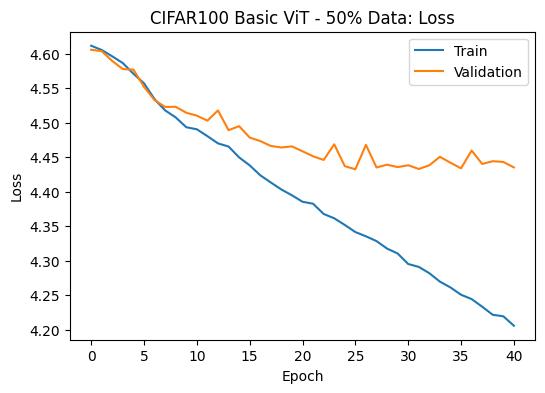

In [16]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} Basic ViT - {data_use}% Data: Loss')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_basic_vit_loss.pdf', format="pdf")
plt.show()


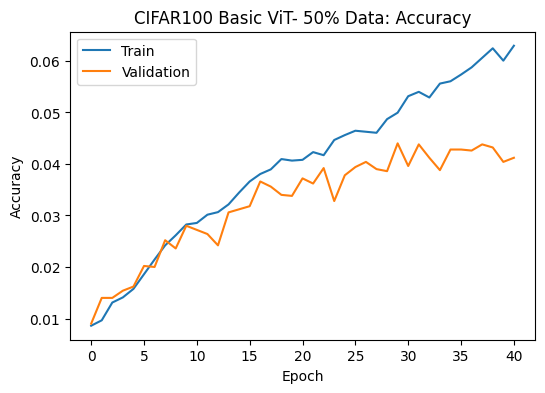

In [17]:
# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} Basic ViT- {data_use}% Data: Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_basic_vit_acc.pdf', format="pdf")
plt.show()


In [18]:
# test on the test set

# Set model to eval mode
model.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients
with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

Testing: 20it [00:01, 12.44it/s]

Test accuracy: 0.0554


In [19]:
# Print classification report and confusion matrix
# Only print if dataset is not CIFAR100. CIFAR100 has too many classes to print
if dataset != "CIFAR100":
    # Print classification report
    print(classification_report(labels, preds))

    # Print confusion matrix
    cm = confusion_matrix(labels, preds)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset} Basic ViT: Confusion Matrix (in %)')
    # save the plot
    plt.savefig(f'{plot_dir}{model_name}_basic_vit_cm.pdf', format="pdf")
    plt.show()

# Self-supervised View Prediction as Weight Initialization Scheme:

Create local and global views

In [20]:
def create_views(x, global_ratio=0.5, local_ratio=0.5, strategy="random"):
    '''
    Function that creates global and local views of an image.

    Parameters:
        x (Tensor): Input image tensor of shape (B, C, H, W)
        global_ratio (float): Fraction of the image to be used for global views
        local_ratio (float): Fraction of the image to be used for local views
        strategy (str): Strategy to use for local views. Options: "random", "central", "jitter"

    Returns:
        global_views (list): List of global views
        local_views (list): List of local views
    '''

    B, C, H, W = x.size()
    
    global_views = []
    local_views = []
    
    # Create 2 Global Views
    for _ in range(2):
        global_view = F.interpolate(x, scale_factor=global_ratio)
        global_view = F.interpolate(global_view, size=(H, W))
        global_views.append(global_view)
    
    # Create 8 Local Views
    for _ in range(8):
        new_H, new_W = int(H * local_ratio), int(W * local_ratio)
        
        if strategy == "random":
            top = random.randint(0, H - new_H)
            left = random.randint(0, W - new_W)
        elif strategy == "central":
            top = (H - new_H) // 2
            left = (W - new_W) // 2
        elif strategy == "jitter":
            crop_ratio = local_ratio + random.uniform(-0.1, 0.1)  # Adding jitter
            new_H_jitter, new_W_jitter = int(H * crop_ratio), int(W * crop_ratio)
            top = random.randint(0, H - new_H_jitter)
            left = random.randint(0, W - new_W_jitter)
        else:
            raise ValueError(f"Unknown local view strategy: {strategy}")
        
        local_view = x[:, :, top:top+new_H, left:left+new_W]
        local_view_resized = F.interpolate(local_view, scale_factor=local_ratio)
        local_view_resized = F.interpolate(local_view_resized, size=(new_H, new_W))
        local_views.append(local_view_resized)
    
    return global_views, local_views


torch.Size([256, 3, 32, 32]) torch.Size([256, 3, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

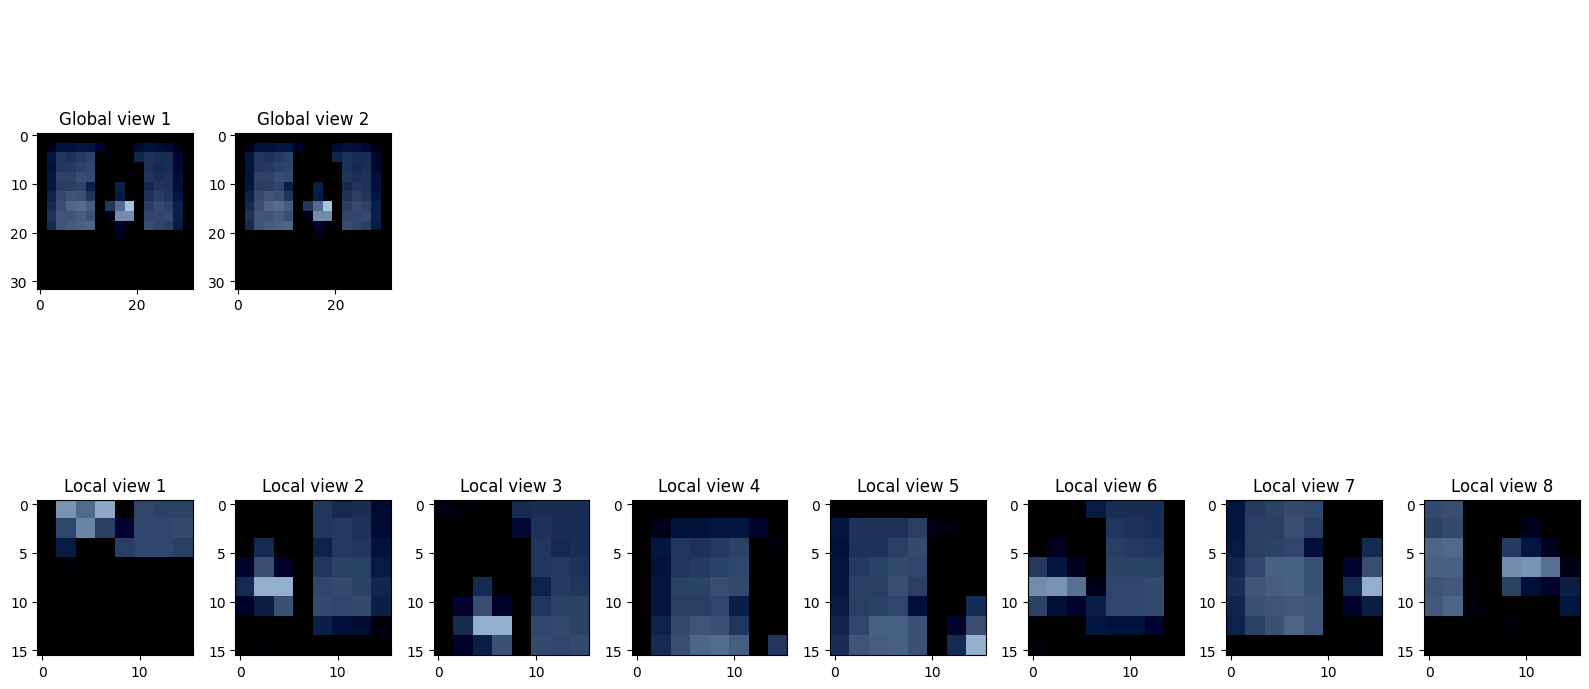

In [21]:
# Debug
for batch_idx, (data, target) in enumerate(train_loader):
    global_views, local_views = create_views(data, global_ratio=0.5, local_ratio=0.5, strategy="jitter")
    
    # Only print the shapes of the first view in each list for brevity
    print(global_views[0].shape, local_views[0].shape)
    break

# Visualization
num_global_views = len(global_views)
num_local_views = len(local_views)

fig, ax = plt.subplots(2, max(num_global_views, num_local_views), figsize=(16, 8))

# Visualize global views
for i in range(num_global_views):
    global_view_img = global_views[i][0].permute(1, 2, 0).cpu().numpy()
    ax[0, i].imshow(global_view_img)
    ax[0, i].set_title(f"Global view {i+1}")

# Visualize local views
for i in range(num_local_views):
    local_view_img = local_views[i][0].permute(1, 2, 0).cpu().numpy()
    ax[1, i].imshow(local_view_img)
    ax[1, i].set_title(f"Local view {i+1}")

# If there are more local views than global views, hide the remaining axes
for i in range(num_global_views, num_local_views):
    ax[0, i].axis("off")

plt.tight_layout()
plt.show()


Create DynamicPositionEmbeddings

In [22]:
class DynamicPositionEmbedding(nn.Module):
    '''
    Class that creates dynamic position embeddings for images using sinusoidal positional encodings.

    Parameters:
        channels (int): Number of channels
        num_patches (int): Number of patches
        embed_dim (int): Embedding dimension

    Returns:
        x (Tensor): Output of dynamic position embedding layer
    '''

    def __init__(self, num_patches, embed_dim):
        super(DynamicPositionEmbedding, self).__init__()

        self.pos_embedding = self.create_pos_embedding(num_patches + 1, embed_dim)


    def create_pos_embedding(self, num_patches, embed_dim):
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pos_embedding = torch.zeros(num_patches, embed_dim)
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        pos_embedding = pos_embedding.unsqueeze(0).transpose(0, 1)
        return nn.Parameter(pos_embedding, requires_grad=False)

    def forward(self, x):
        x = x + self.pos_embedding[:x.size(1)].squeeze(1) # Add position embeddings to both patch embeddings and CLS token.
        return x

In [23]:
# # Debug
# # Create an instance of PatchEmbedding and DynamicPositionEmbedding
# patch_embed = PatchEmbedding(image_size=28, patch_size=7, in_channels=1, embed_dim=4)  # Assuming these parameters
# dynamic_pos_embed = DynamicPositionEmbedding(num_patches=17, embed_dim=4)

# x = torch.randn(1, 1, 28, 28)
# print(f"Input shape: {x.shape}")
# x = patch_embed(x)
# print(f"Patch embedding output shape: {x.shape}")
# x = dynamic_pos_embed(x)
# print(f"Dynamic position embedding output shape: {x.shape}")


# # Test the flow
# x = torch.randn(1, 1, 28, 28)
# print(f"Input shape: {x.shape}")
# x = patch_embed(x)
# print(f"Patch embedding output shape: {x.shape}")
# x = dynamic_pos_embed(x)
# print(f"Dynamic position embedding output shape: {x.shape}")

Define EMA class for exponential moving average of model weights for the teacher ViT

In [24]:
class EMA:
    '''
    Class to update and maintain the Exponential Moving Average (EMA) of model parameters.
    
    Parameters:
        model (nn.Module): PyTorch model for which the EMA needs to be maintained.
        decay (float): Decay rate for the moving average. Value should be between 0 and 1.
                       Higher values give more importance to recent model parameters.
    
    Attributes:
        model (nn.Module): PyTorch model.
        decay (float): Decay rate for the moving average.
        shadow (dict): Dictionary to store the shadow weights.
        backup (dict): Dictionary to store the backup of the original model weights.
    '''
    
    def __init__(self, model, ema_decay, num_epochs, optimizer):
        self.model = model
        self.decay_scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs, eta_min=0.001, last_epoch=-1, verbose=False)
        self.initial_decay = ema_decay
        self.shadow = {}
        self.backup = {}

        # Initialize the shadow weights with the model parameters
        for name, param in model.named_parameters():
            self.shadow[name] = param.data.clone()

    def apply(self):
        """
        Apply the EMA to the model weights. The model's weights are replaced by the shadow weights.
        """

        # Update decay based on the cosine schedule
        self.decay = self.initial_decay + (1 - self.initial_decay) * self.decay_scheduler.get_last_lr()[0]

        # Backup current model parameters
        for name, param in self.model.named_parameters():
            self.backup[name] = param.data.clone()

        # Apply EMA to get the shadow weights
        for name, param in self.model.named_parameters():
            self.shadow[name] = self.decay * self.shadow[name] + (1.0 - self.decay) * param.data
            param.data = self.shadow[name]

        # Step the scheduler for the next iteration
        self.decay_scheduler.step()

    def restore(self):
        """
        Restore the model's weights from the backup. This reverts the effects of the `apply` method.
        """
        # Restore model parameters from the backup
        for name, param in self.model.named_parameters():
            param.data = self.backup[name]

In [25]:
def center_and_sharpen(features, sharpen_value=0.5):
    '''
    Center and sharpen the features.
    
    Parameters:
        features (torch.Tensor): The features tensor.
        sharpen_value (float): Value used for sharpening.
    
    Returns:
        torch.Tensor: Centered and sharpened features.
    '''
    # Centering
    centered_features = features - features.mean(dim=0)

    # Sharpening
    sharpened_features = torch.nn.functional.softmax(centered_features / sharpen_value, dim=1)

    return sharpened_features

Create the VisionTransformerDPE class and instantiate the teacher ViT and the student ViT

In [26]:
class VisionTransformerDPE(nn.Module):
    '''
    Vision transformer architecture with Dynamic Position Embeddings.

    Parameters:
        image_size (int): Size of image
        patch_size (int): Size of patch
        in_channels (int): Number of input channels
        embed_dim (int): Embedding dimension
        depth (int): Depth
        heads (int): Number of heads
        mlp_dim (int): Dimension of MLP
        dropout (float): Dropout probability
        num_classes (int): Number of classes

    Returns:
        x (Tensor): Output of VisionTransformer
    '''
    
    def __init__(self, 
                 image_size: int, 
                 patch_size: int, 
                 in_channels: int, 
                 embed_dim: int, 
                 depth: int, 
                 heads: int, 
                 mlp_dim: int,
                 num_classes: int, 
                 dropout: float = 0., 
                 mlp_head_units = [2048, 1024]):
        super().__init__()        
        # Patch embedding layer
        self.patch_embed = PatchEmbedding(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        # Initializing cls_token and pos_embed with random values
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))        
        # Create the Dynamic Positional Embedding layer
        num_patches = (image_size // patch_size) ** 2
        self.dynamic_pos_embed = DynamicPositionEmbedding(num_patches, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.transformer_encoder = nn.ModuleList([TransformerEncoderBlock(dim=embed_dim, heads=heads, dim_head=embed_dim // heads, mlp_dim=mlp_dim, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_head_units[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[0], mlp_head_units[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_head_units[1], num_classes)
        )
    def forward(self, x):
        B = x.shape[0]  # batch_size
        x = self.patch_embed(x)
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=B)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Use the DynamicPositionEmbedding for adding the positional embeddings
        x = self.dynamic_pos_embed(x)
        
        x = self.dropout(x)

        for transformer_encoder in self.transformer_encoder:
            x = transformer_encoder(x)

        x = self.norm(x)
        x = x[:, 0]  # Take the cls_token representation
        x = self.mlp_head(x)

        return x


Define the self-supervised loss

In [27]:
class SelfSupervisedLoss(nn.Module):
    '''
    Implements the self-supervised loss for Vision Transformer as described in 
    "How to Train Vision Transformers on Small-scale Datasets".

    This loss combines both global and local views. Specifically, 
    it computes a loss based on the negative sum of the elementwise product 
    of the student's outputs and the logarithm of the teacher's outputs.

    Attributes:
        None

    Methods:
        forward(student_global, teacher_global, student_locals, teacher_locals): Computes the self-supervised loss.
    '''

    def __init__(self, temperature=0.1):
        super(SelfSupervisedLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_global, teacher_global, student_locals, teacher_locals):
        '''
        Computes the self-supervised loss.

        Parameters:
        - student_global (torch.Tensor): Global view output from the student network.
        - teacher_global (torch.Tensor): Global view output from the teacher network.
        - student_locals (List[torch.Tensor]): List of local view outputs from the student network.
        - teacher_locals (List[torch.Tensor]): List of local view outputs from the teacher network.

        Returns:
        - loss (torch.Tensor): Computed self-supervised loss combining both global and local views.
        '''

        # Temperature-scaled cross-entropy loss
        teacher_global = torch.nn.functional.log_softmax(teacher_global / self.temperature, dim=-1)
        student_global = torch.nn.functional.softmax(student_global / self.temperature, dim=-1)

        # Compute the global view loss component
        global_loss = -torch.mean(torch.sum(student_global * teacher_global, dim=-1))

        # Compute the local view loss component
        teacher_locals = [torch.nn.functional.log_softmax(t_local / self.temperature, dim=-1) for t_local in teacher_locals]
        student_locals = [torch.nn.functional.softmax(s_local / self.temperature, dim=-1) for s_local in student_locals]

        local_losses = [-torch.mean(torch.sum(s_local * t_local, dim=-1)) for s_local, t_local in zip(student_locals, teacher_locals)]
        
        # Average the local losses
        total_local_loss = sum(local_losses) / len(local_losses)

        # Combine the losses
        loss = global_loss + total_local_loss
        return loss

Define the training loops


1. **Train the Student (Self-Supervised)**: Using the self-supervised approach, the student model is trained to mimic the teacher's outputs on low-resolution local and global views. During this phase, the student learns inductive biases from the teacher's representations.

2. **Fine-tune the Student (Still Self-Supervised)**: Depending on the specifics, there might be additional fine-tuning of the student model within the self-supervised framework to further optimize its performance.

3. **Transfer the Student Weights to Standard ViT (Supervised)**: The weights of the student model are then used to initialize a standard Vision Transformer. This ViT is then trained using supervised learning on actual labeled data from the small-scale dataset.

This process leverages the inductive biases learned during self-supervised training to improve the training and generalization of the Vision Transformer on small datasets. The teacher model aids in the self-supervised learning, but the weights transferred for supervised fine-tuning are from the student.

In [28]:
def self_supervised_training(student, teacher, optimizer, ema_updater, epochs, train_loader, val_loader, scheduler, device, criterion):
    '''
    Train Vision Transformer in a self-supervised manner.
    
    Parameters:
        student (nn.Module): Student Vision Transformer model
        teacher (nn.Module): Teacher Vision Transformer model
        optimizer (nn.Module): Optimizer
        ema_updater (EMA): EMA updater
        epochs (int): Number of epochs
        train_loader (DataLoader): Training set dataloader
        val_loader (DataLoader): Validation set dataloader
        scheduler (nn.Module): Learning rate scheduler
        device (str): Device to use
        criterion (nn.Module): Loss function

    Returns:
        None
    '''
    
    student.train()
    teacher.eval()  # Teacher always in eval mode
    loss_fn = SelfSupervisedLoss()
    best_val_loss = float('inf')  # Initialize best validation loss to infinity§

    # create save directory if it doesn't exist
    save_dir = '../trained_models/dino/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Start timer
    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0.0
        for images, _ in tqdm(train_loader, desc="Training"):  # We don't need labels in this phase
            images = images.to(device)
            
            # Create views
            global_views, local_views = create_views(images)
            
            total_view_loss = 0
            for i in range(len(global_views)):
                global_view = global_views[i].to(device)
                local_view = local_views[i].to(device)
                
                # Forward pass
                with torch.no_grad():
                    teacher_features = teacher(global_view)
                    teacher_features = center_and_sharpen(teacher_features)  # Apply centering and sharpening
                    teacher_features = F.normalize(teacher_features, dim=1)


                student_global_features, student_local_features = student(global_view), student(local_view)
                student_global_features = F.normalize(student_global_features, dim=1)
                
                # Loss computation for this view
                loss = loss_fn(student_global_features, teacher_features, student_local_features, teacher_features)
                total_view_loss += loss
            
            # Average the loss for all views
            avg_view_loss = total_view_loss / len(global_views)
            total_loss += avg_view_loss.item()
            
            # Backpropagate based on avg_view_loss
            optimizer.zero_grad()
            avg_view_loss.backward()
            optimizer.step()

            # Update teacher with EMA of student weights
            ema_updater.apply()

        # Average loss for the whole epoch
        avg_loss = total_loss / len(train_loader)
    
        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")

        # Use the validation set to adapt the learning rate
        with torch.no_grad():
            val_loss = 0.0
            student.eval()  # Switch student to evaluation mode

            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Validation Loss after Epoch [{epoch+1}/{epochs}]: {avg_val_loss:.4f}")

            # Save the model if the validation loss improves
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(student.state_dict(), f'{save_dir}{dataset}_{data_use}_self_supervised_best_student_weights.pth')

                print("Saved improved model with validation loss {:.4f}".format(avg_val_loss))

        student.train()  # Switch student back to training mode after validation

    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")

    # At the end of training, you might want to restore the student's original weights
    ema_updater.restore()
    print("Self-supervised training complete!")


In [29]:
def supervised_training(student, optimizer, criterion, num_epochs, train_loader, val_loader, scheduler, device):
    '''
    Fine-tune the Vision Transformer in a supervised manner.

    Parameters:
    - student (nn.Module): The student model.
    - optimizer (torch.optim.Optimizer): Optimizer for the student model.
    - criterion (nn.Module): Loss function.
    - num_epochs (int): Number of training epochs.
    - train_loader (DataLoader): DataLoader for the training set.
    - val_loader (DataLoader): DataLoader for the validation set.
    - scheduler: Learning rate scheduler.
    - device (torch.device): Device to which tensors will be moved.

    Returns:
    None
    '''
    
    best_val_loss = float('inf')  # Set the best validation loss to infinity

    # create save directory if it doesn't exist
    save_dir = '../trained_models/dino/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Start timer
    start_time = time.time()

    for epoch in range(num_epochs):
        student.train()
        
        total_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = student(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # Average loss and accuracy
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
        # Use the validation set to adapt the learning rate
        with torch.no_grad():
            val_loss = 0.0
            student.eval()
            
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            scheduler.step(avg_val_loss)

            print(f"Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(student.state_dict(), f'{save_dir}{dataset}_{data_use}_supervised_best_student_weights.pth')
    
    # Record the end time for training
    end_time = time.time()
    # Calculate the total training time
    total_time_seconds = end_time - start_time
    if total_time_seconds < 60:
        print(f"Total training time: {total_time_seconds:.2f} seconds")
    else:
        total_time_minutes = total_time_seconds / 60
        print(f"Total training time: {total_time_minutes:.2f} minutes")

    print("Supervised fine-tuning complete!")


### Student Teacher Training



In [30]:
# Initialize models
teacher = VisionTransformerDPE(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes, 
)

half_image_size = 0.5*image_size

student = VisionTransformerDPE(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes,
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.5, verbose=True)

# Print model summary
summary(teacher.cpu(), input_size=(in_channels, image_size, image_size))

# Print model summary
summary(student.cpu(), input_size=(in_channels, image_size, image_size))

# Send models to device
teacher = teacher.to(device)
student = student.to(device)

# The teacher starts off with the same weights as the student
teacher.load_state_dict(student.state_dict())

# Initialize the EMA updater for the teacher model
ema_updater = EMA(student, ema_decay, self_supervised_epochs, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]          12,352
    PatchEmbedding-2               [-1, 16, 64]               0
DynamicPositionEmbedding-3               [-1, 17, 64]               0
           Dropout-4               [-1, 17, 64]               0
         LayerNorm-5               [-1, 17, 64]             128
            Linear-6              [-1, 17, 192]          12,288
           Softmax-7            [-1, 4, 17, 17]               0
            Linear-8               [-1, 17, 64]           4,160
         Attention-9               [-1, 17, 64]               0
          Dropout-10               [-1, 17, 64]               0
        LayerNorm-11               [-1, 17, 64]             128
           Linear-12             [-1, 17, 2048]         133,120
             GELU-13             [-1, 17, 2048]               0
             GELU-14             

In [31]:
# Call the self_supervised_training function to start the self-supervised phase
self_supervised_training(student, teacher, optimizer, ema_updater, self_supervised_epochs, 
                         train_loader, val_loader, scheduler, device, criterion)

Training: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [1/20] - Training Loss: 9.0958


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [1/20]: 27.3575
Saved improved model with validation loss 27.3575


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [2/20] - Training Loss: 9.0783


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [2/20]: 51.9340


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [3/20] - Training Loss: 9.0901


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Validation Loss after Epoch [3/20]: 32.4068


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [4/20] - Training Loss: 9.0698


Validation: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Validation Loss after Epoch [4/20]: 30.9801


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [5/20] - Training Loss: 9.0677


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [5/20]: 18.5965
Saved improved model with validation loss 18.5965


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [6/20] - Training Loss: 9.0654


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [6/20]: 14.6421
Saved improved model with validation loss 14.6421


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [7/20] - Training Loss: 9.0645


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Validation Loss after Epoch [7/20]: 10.3107
Saved improved model with validation loss 10.3107


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [8/20] - Training Loss: 9.0652


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [8/20]: 8.8350
Saved improved model with validation loss 8.8350


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [9/20] - Training Loss: 9.0636


Validation: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Validation Loss after Epoch [9/20]: 6.6137
Saved improved model with validation loss 6.6137


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [10/20] - Training Loss: 9.0632


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [10/20]: 5.8406
Saved improved model with validation loss 5.8406


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [11/20] - Training Loss: 9.0633


Validation: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Validation Loss after Epoch [11/20]: 5.1197
Saved improved model with validation loss 5.1197


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [12/20] - Training Loss: 9.0621


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [12/20]: 4.7076
Saved improved model with validation loss 4.7076


Training: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch [13/20] - Training Loss: 9.0613


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [13/20]: 4.7204


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [14/20] - Training Loss: 9.0624


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [14/20]: 4.7577


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [15/20] - Training Loss: 9.0611


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Validation Loss after Epoch [15/20]: 4.7113


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [16/20] - Training Loss: 9.0613


Validation: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Validation Loss after Epoch [16/20]: 4.6785
Saved improved model with validation loss 4.6785


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [17/20] - Training Loss: 9.0611


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [17/20]: 4.7608


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [18/20] - Training Loss: 9.0623


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [18/20]: 4.7263


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [19/20] - Training Loss: 9.0613


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [19/20]: 4.6469
Saved improved model with validation loss 4.6469


Training: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch [20/20] - Training Loss: 9.0609


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]

Validation Loss after Epoch [20/20]: 4.6294
Saved improved model with validation loss 4.6294
Total training time: 27.16 minutes
Self-supervised training complete!


In [32]:
# Load the saved state_dict
saved_state_dict = torch.load(f'../trained_models/dino/{dataset}_{data_use}_self_supervised_best_student_weights.pth')

# Create a new state_dict that excludes 'mlp_head'
new_state_dict = {k: v for k, v in saved_state_dict.items() if not k.startswith('mlp_head')}

# Load this state_dict into student (it won't touch the mlp_head)
student.load_state_dict(new_state_dict, strict=False)

# Replace the self-supervised projection head with a new classifier head
student.mlp_head = nn.Sequential(
    nn.Linear(projection_dim, mlp_head_units[0]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(mlp_head_units[0], mlp_head_units[1]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(mlp_head_units[1], num_classes)
).to(device)

# Reset optimizer for the supervised phase
optimizer = optim.Adam(student.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Reset scheduler for the supervised phase
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.5, verbose=True)

# Call the supervised_training function to start the supervised phase
supervised_training(student, optimizer, criterion, fine_tune_epochs, train_loader, val_loader, scheduler, device)


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [1/20] - Loss: 4.6098, Accuracy: 1.01%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [1/20]: 4.5976


Training: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Epoch [2/20] - Loss: 4.5892, Accuracy: 1.28%


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [2/20]: 4.5844


Training: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Epoch [3/20] - Loss: 4.5736, Accuracy: 1.64%


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation Loss after Epoch [3/20]: 4.5587


Training: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch [4/20] - Loss: 4.5518, Accuracy: 1.75%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Validation Loss after Epoch [4/20]: 4.5550


Training: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch [5/20] - Loss: 4.5420, Accuracy: 2.15%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [5/20]: 4.5383


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [6/20] - Loss: 4.5311, Accuracy: 2.31%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Validation Loss after Epoch [6/20]: 4.5389


Training: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch [7/20] - Loss: 4.5215, Accuracy: 2.38%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [7/20]: 4.5271


Training: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch [8/20] - Loss: 4.5129, Accuracy: 2.52%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [8/20]: 4.5255


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [9/20] - Loss: 4.5092, Accuracy: 2.58%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [9/20]: 4.5233


Training: 100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Epoch [10/20] - Loss: 4.5000, Accuracy: 2.56%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [10/20]: 4.5328


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [11/20] - Loss: 4.4941, Accuracy: 2.76%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [11/20]: 4.5148


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [12/20] - Loss: 4.4862, Accuracy: 2.96%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [12/20]: 4.5130


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [13/20] - Loss: 4.4797, Accuracy: 2.87%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [13/20]: 4.5140


Training: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Epoch [14/20] - Loss: 4.4756, Accuracy: 3.02%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Validation Loss after Epoch [14/20]: 4.5111


Training: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Epoch [15/20] - Loss: 4.4712, Accuracy: 3.00%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [15/20]: 4.5046


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [16/20] - Loss: 4.4631, Accuracy: 3.21%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation Loss after Epoch [16/20]: 4.5043


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [17/20] - Loss: 4.4563, Accuracy: 3.21%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Validation Loss after Epoch [17/20]: 4.5022


Training: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Epoch [18/20] - Loss: 4.4500, Accuracy: 3.33%


Validation: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Validation Loss after Epoch [18/20]: 4.5014


Training: 100%|██████████| 79/79 [00:23<00:00,  3.37it/s]


Epoch [19/20] - Loss: 4.4421, Accuracy: 3.26%


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Validation Loss after Epoch [19/20]: 4.4926


Training: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Epoch [20/20] - Loss: 4.4346, Accuracy: 3.52%


Validation: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]

Validation Loss after Epoch [20/20]: 4.5036
Total training time: 11.06 minutes
Supervised fine-tuning complete!


In [33]:
# Load the saved model's weights
SAVE_PATH = f'../trained_models/dino/{dataset}_{data_use}_supervised_best_student_weights.pth'
student.load_state_dict(torch.load(SAVE_PATH, map_location=device))

# Instantiate new model representing the basic ViT to which we will transfer the weights
basic_vit = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=projection_dim,
    depth=transformer_layers,
    heads=num_heads,
    mlp_dim=mlp_head_units[0],
    dropout=dropout,
    num_classes=num_classes,
).to(device)

# Transfer Patch Embedding Layer
basic_vit.patch_embed.load_state_dict(student.patch_embed.state_dict())

# Transfer Transformer Encoder Layers
for teacher_block, student_block in zip(basic_vit.transformer_encoder, student.transformer_encoder):
    teacher_block.load_state_dict(student_block.state_dict())

# Transfer MLP Head
basic_vit.mlp_head.load_state_dict(student.mlp_head.state_dict())

# Transfer CLS Token
basic_vit.cls_token.data = student.cls_token.data.clone()


In [34]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(basic_vit.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience_value, factor=0.5, verbose=True)

# Set model_name for DINO training
model_name = f"{dataset}_{data_use}_DINO_classifier"

# Train model
basic_vit, train_losses, val_losses, train_acc, val_acc = train(basic_vit, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=num_epochs, scheduler=scheduler, patience=patience_value)

Epoch 1/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 1/50 - Train Loss: 4.4509, Train Acc: 0.0350, Val Loss: 4.4996, Val Acc: 0.0322


Epoch 2/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 2/50 - Train Loss: 4.4254, Train Acc: 0.0361, Val Loss: 4.5070, Val Acc: 0.0326


Epoch 3/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 3/50 - Train Loss: 4.4177, Train Acc: 0.0364, Val Loss: 4.4964, Val Acc: 0.0334


Epoch 4/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 4/50 - Train Loss: 4.4122, Train Acc: 0.0373, Val Loss: 4.4898, Val Acc: 0.0306


Epoch 5/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 5/50 - Train Loss: 4.3989, Train Acc: 0.0387, Val Loss: 4.4854, Val Acc: 0.0296


Epoch 6/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 6/50 - Train Loss: 4.3928, Train Acc: 0.0380, Val Loss: 4.4891, Val Acc: 0.0334


Epoch 7/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 7/50 - Train Loss: 4.3819, Train Acc: 0.0402, Val Loss: 4.4887, Val Acc: 0.0340


Epoch 8/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 8/50 - Train Loss: 4.3747, Train Acc: 0.0419, Val Loss: 4.4884, Val Acc: 0.0318


Epoch 9/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Epoch 9/50 - Train Loss: 4.3635, Train Acc: 0.0408, Val Loss: 4.4903, Val Acc: 0.0328


Epoch 10/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 10/50 - Train Loss: 4.3554, Train Acc: 0.0430, Val Loss: 4.4942, Val Acc: 0.0342


Epoch 11/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 11/50 - Train Loss: 4.3445, Train Acc: 0.0441, Val Loss: 4.4925, Val Acc: 0.0322


Epoch 12/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 12/50 - Train Loss: 4.3365, Train Acc: 0.0458, Val Loss: 4.4990, Val Acc: 0.0332


Epoch 13/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 13/50 - Train Loss: 4.3230, Train Acc: 0.0463, Val Loss: 4.4979, Val Acc: 0.0334


Epoch 14/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Epoch 14/50 - Train Loss: 4.3194, Train Acc: 0.0463, Val Loss: 4.5087, Val Acc: 0.0308


Epoch 15/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Epoch 15/50 - Train Loss: 4.3078, Train Acc: 0.0489, Val Loss: 4.5398, Val Acc: 0.0346


Epoch 16/50 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Epoch 16/50 - Train Loss: 4.2995, Train Acc: 0.0502, Val Loss: 4.5030, Val Acc: 0.0326


Epoch 17/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Epoch 17/50 - Train Loss: 4.2904, Train Acc: 0.0501, Val Loss: 4.5140, Val Acc: 0.0336


Epoch 18/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 18/50 - Train Loss: 4.2812, Train Acc: 0.0507, Val Loss: 4.5191, Val Acc: 0.0322


Epoch 19/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 19/50 - Train Loss: 4.2761, Train Acc: 0.0492, Val Loss: 4.5365, Val Acc: 0.0306


Epoch 20/50 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]

Epoch 20/50 - Train Loss: 4.2659, Train Acc: 0.0518, Val Loss: 4.5210, Val Acc: 0.0308
Early stopping due to no improvement in validation loss.
Total training time: 10.94 minutes


In [35]:
# test on the test set

# Set model to eval mode
basic_vit.eval()

# Initialize lists to store predictions and labels
preds = []
labels = []

# Turn off gradients

with torch.no_grad():
    # Iterate over test data
    for batch_idx, (data, target) in tqdm(enumerate(test_loader), desc="Testing"):
        # Send data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = basic_vit(data)

        # Get predicted class
        pred = output.argmax(dim=1, keepdim=True)

        # Save predictions and labels for computing metrics later
        preds.extend(pred.cpu().numpy())
        labels.extend(target.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(labels, preds)
print(f"Test accuracy: {accuracy:.4f}")

Testing: 20it [00:01, 12.50it/s]

Test accuracy: 0.0444


In [36]:
# Print classification report and confusion matrix
# Only print if dataset is not CIFAR100. CIFAR100 has too many classes to print
if dataset != "CIFAR100":
    # Print classification report
    print(classification_report(labels, preds))

    # Print confusion matrix
    cm = confusion_matrix(labels, preds)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset} DINO ViT - {data_use}% Data: Confusion Matrix (in %)')
    # save the plot
    plt.savefig(f'{plot_dir}{model_name}_dino_vit_cm.pdf', format="pdf")
    plt.show()

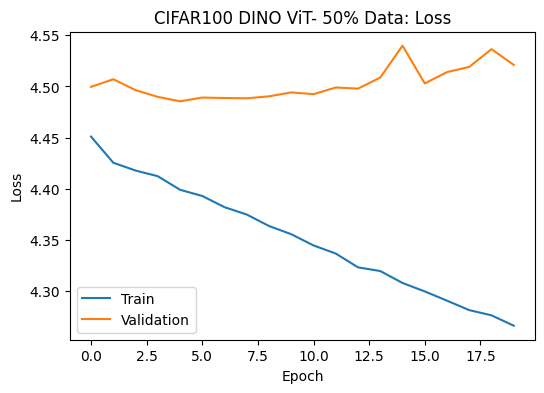

In [37]:
# Plot losses
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} DINO ViT- {data_use}% Data: Loss')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_dino_vit_loss.pdf', format="pdf")
plt.show()


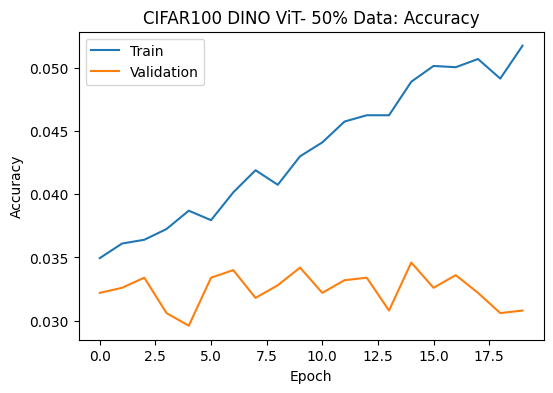

In [38]:
# Plot accuracies
plt.figure(figsize=(6, 4))
plt.title(f'{dataset} DINO ViT- {data_use}% Data: Accuracy')
# move list to cpu
train_acc = [i.cpu() for i in train_acc]
val_acc = [i.cpu() for i in val_acc]
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# save the plot
plt.savefig(f'{plot_dir}{model_name}_dino_vit_acc.pdf', format="pdf")
plt.show()
